In [53]:
import os
import pickle
import random
import math
from collections import namedtuple, deque

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

import seaborn as sns

import torch

In [2]:
log = pd.read_csv("./data/log.csv")

# Code Snippets

## IQL_DATALOADER

In [155]:
training_data_rows = []

for (episode, agentIndex), group in log.groupby(["episode", "agentIndex"]):
    # 按照tick排序
    group = group.sort_values('tick')
    
    # 计算每个tick的流量总个数
    group['tick_volume'] = group.groupby('tick')['tick'].transform('size')
    
    # 计算每个tick的流量总和
    tick_volume_sum = group.groupby('tick')['tick_volume'].first()
    
    # 使用cumsum计算历史流量总个数（不包括当前tick）
    historical_volume = tick_volume_sum.cumsum().shift(1).fillna(0).astype(int)
    group['historical_volume'] = group['tick'].map(historical_volume)
    
    # 使用rolling和shift计算前三个tick的流量总个数（不包括当前tick）
    last_3_ticks_volume = tick_volume_sum.rolling(window=3, min_periods=1).sum().shift(1).fillna(0).astype(int)
    group['last_3_ticks_volume'] = group['tick'].map(last_3_ticks_volume)
    
    # 对每个tick内的数据进行聚合
    group_agg = group.groupby('tick').agg({
        'bid': 'mean',
        'marketPrice': 'mean',
        'Reward': 'mean',
        'status': 'mean',
        'pvValue': 'mean',
        'tick_volume': 'first'
    }).reset_index()
    
    # 计算历史所有tick的平均值，不包括当前tick
    for col in ['bid', 'marketPrice', 'Reward', 'status', 'pvValue']:
        group_agg[f'avg_{col}_all'] = group_agg[col].expanding().mean().shift(1)
        group_agg[f'avg_{col}_last_3'] = group_agg[col].rolling(window=3, min_periods=1).mean().shift(1)

    # 将聚合后的数据合并回原始group
    group = group.merge(group_agg, on='tick', suffixes=('', '_agg'))
    
    for tick in group['tick'].unique():
        current_tick_data = group[group['tick'] == tick]

        # 计算state
        budget = current_tick_data['budget'].iloc[0]
        remainingBudget = current_tick_data['remainingBudget'].iloc[0]
        timeleft = (24 - tick) / 24
        bgtleft = remainingBudget / budget if budget > 0 else 0

        # 从current_tick_data获取当前tick的特征
        current_tick_data.fillna(0, inplace=True)
        state_features = current_tick_data.iloc[0].to_dict()
    
        state = (
            timeleft, bgtleft,
            state_features['avg_bid_all'],
            state_features['avg_bid_last_3'],
            state_features['avg_marketPrice_all'],
            state_features['avg_pvValue_all'],
            state_features['avg_Reward_all'],
            state_features['avg_status_all'],
            state_features['avg_marketPrice_last_3'],
            state_features['avg_pvValue_last_3'],
            state_features['avg_Reward_last_3'],
            state_features['avg_status_last_3'],
            state_features['pvValue_agg'],
            state_features['tick_volume_agg'],
            state_features['last_3_ticks_volume'],
            state_features['historical_volume']
        )
        
        # 计算该tick的action
        total_bid = current_tick_data['bid'].sum()
        total_value = current_tick_data['pvValue'].sum()
        action = total_bid / total_value if total_value > 0 else 0
        
        # 计算该tick的reward
        reward = current_tick_data[current_tick_data['status'] == 1]['Reward'].sum()
        
        # 计算done
        tickNum = 23
        done = 1 if tick == tickNum or current_tick_data['done'].iloc[0] == 1 else 0
        
        # 添加到训练数据DataFrame
        training_data_rows.append({
            'episode': episode,
            'agentIndex': agentIndex,
            'tick': tick,
            'state': state,
            'action': action,
            'reward': reward,
            'done': done
        })
        
    # 将训练数据转换为DataFrame
    training_data = pd.DataFrame(training_data_rows)
    training_data = training_data.sort_values(by=['episode', 'agentIndex', 'tick'])
    
    # 计算next_state
    training_data['next_state'] = training_data.groupby(['episode', 'agentIndex'])['state'].shift(-1)
    training_data.loc[training_data['done'] == 1, 'next_state'] = None

/Users/rongzhimai/Library/Caches/pypoetry/virtualenvs/bidding-FwXjcHaf-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:4144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## NORMALIZE_STATE

In [65]:
state_dim = 16
normalize_indices=[13, 14, 15]

state_columns = [f'state{i}' for i in range(state_dim)]
next_state_columns = [f'next_state{i}' for i in range(state_dim)]

for i, (state_col, next_state_col) in enumerate(zip(state_columns, next_state_columns)):
    training_data[state_col] = training_data['state'].apply(lambda x: x[i])
    training_data[next_state_col] = training_data['next_state'].apply(lambda x: x[i] if x is not None else 0.0)

In [67]:
stats = {
    i: {
        'min': training_data[state_columns[i]].min(),
        'max': training_data[state_columns[i]].max(),
        'mean': training_data[state_columns[i]].mean(),
        'std': training_data[state_columns[i]].std()
    }
    for i in normalize_indices
}

In [69]:
# 构建归一化后的'state'和'next_state'
for state_col, next_state_col in zip(state_columns, next_state_columns):
    if int(state_col.replace('state', '')) in normalize_indices:
        min_val = stats[int(state_col.replace('state', ''))]['min']
        max_val = stats[int(state_col.replace('state', ''))]['max']
        training_data[f'normalize_{state_col}'] = (training_data[state_col] - min_val) / (max_val - min_val)
        training_data[f'normalize_{next_state_col}'] = (training_data[next_state_col] - min_val) / (max_val - min_val)
    else:
        training_data[f'normalize_{state_col}'] = training_data[state_col]
        training_data[f'normalize_{next_state_col}'] = training_data[next_state_col]

In [71]:
# 重新组合归一化后的'state'和'next_state'列为元组
training_data['normalize_state'] = training_data.apply(
    lambda row: tuple(row[f'normalize_{state_col}'] for state_col in state_columns), axis=1)
training_data['normalize_nextstate'] = training_data.apply(
    lambda row: tuple(row[f'normalize_{next_state_col}'] for next_state_col in next_state_columns), axis=1)

## REPLAY_BUFFER

In [74]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    """
    强化学习储存训练数据的训练池
    """

    def __init__(self):
        self.memory = []

    def push(self, state, action, reward, next_state, done):
        """保存一个经验元组"""
        experience = Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self, batch_size):
        """随机抽取一批经验"""
        tem = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*tem)
        states, actions, rewards, next_states, dones = np.stack(states), np.stack(actions), np.stack(rewards), np.stack(
            next_states), np.stack(dones)
        states, actions, rewards, next_states, dones = torch.FloatTensor(states), torch.FloatTensor(
            actions), torch.FloatTensor(rewards), torch.FloatTensor(next_states), torch.FloatTensor(dones)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """返回当前缓冲区的大小"""
        return len(self.memory)

In [79]:
buffer = ReplayBuffer()

for i in range(1000):
    buffer.push(np.array([1, 2, 3]), np.array(4), np.array(5), np.array([6, 7, 8]), np.array(0))

print(buffer.sample(20))

(tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]]), tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.]), tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5.]), tensor([[6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [

## TEST_DATALOADER

In [118]:
class TestDataLoader:
    """
    离线评测数据加载器。
    """

    def __init__(self, file_path="./data/log.csv"):
        """
        初始化数据加载器。

        Args:
            file_path (str): 训练数据文件路径。
        """
        self.file_path = file_path
        self.raw_data_path = os.path.join(os.path.dirname(file_path), "raw_data.pickle")
        self.raw_data = self._get_raw_data()
        self.keys, self.test_dict = self._get_test_data_dict()

    def _get_raw_data(self):
        """
        从pickle文件中读取原始数据。

        Returns:
            pd.DataFrame: 原始数据。
        """
        with open(self.raw_data_path, 'rb') as file:
            return pickle.load(file)

    def _get_test_data_dict(self):
        """
        按照episode和agentIndex对原始数据进行分组并排序。

        Returns:
            list: 分组的键列表。
            dict: 分组的数据字典。
        """
        grouped_data = self.raw_data.sort_values('tick').groupby(['episode', 'agentIndex'])
        data_dict = {key: group for key, group in grouped_data}
        return list(data_dict.keys()), data_dict

    def mock_data(self, key):
        """
        根据episode和agentIndex获取训练数据，并构造测试数据。

        Args:
            key (tuple): 组合键，包含episode和agentIndex。

        Returns:
            int: tick数目。
            list: 每个tick的市场价格列表。
            list: 每个tick的pv值列表。
        """
        data = self.test_dict[key]
        pv_values = data.groupby('tick')['pvValue'].apply(list).apply(np.array).tolist()
        market_prices = data.groupby('tick')['marketPrice'].apply(list).apply(np.array).tolist()
        num_tick = len(pv_values)
        return num_tick, market_prices, pv_values

In [119]:
data_loader = TestDataLoader(file_path='./data/log.csv')

## OFFLINE_ENV

In [111]:
class OfflineEnv:
    """
    模拟广告竞价环境。
    """

    def __init__(self, min_remaining_budget: float = 0.01):
        """
        初始化模拟环境。

        :param min_remaining_budget: 出价智能体允许的最小剩余预算。
        """
        self.min_remaining_budget = min_remaining_budget

    def simulate_ad_bidding(self, pv_values: np.ndarray, bids: np.ndarray, market_prices: np.ndarray):
        """
        模拟广告竞价过程。

        :param pv_values: 各流量点的价值。
        :param bids: 出价智能体的出价。
        :param market_prices: 各流量点的市场价格。
        :return: 竞得的价值，花费，以及是否竞得的状态。
        """
        # 计算广告主是否竞得每个流量点
        tick_status = bids >= market_prices
        # 计算广告主的花费和获得的价值
        tick_cost = market_prices * tick_status
        tick_value = pv_values * tick_status

        return tick_value, tick_cost, tick_status

In [112]:
env = OfflineEnv()

## RUN_TEST

In [114]:
from bidding_train_env.agent import PlayerAgent

In [188]:
# 取一个（episode, agentIndex）的数据构建测试数据
keys, test_dict = data_loader.keys, data_loader.test_dict
total_rewards = 0

for key in keys:
    print(f'KEY: {key} Begin')
    # agent = PlayerAgent()

    num_tick, market_prices, pvalues = data_loader.mock_data(key)
    rewards = np.zeros(num_tick)
    history = {
        'bid': [],
        'status': [],
        'reward': [],
        'market_price': [],
        'pv_values': []
    }

    for tick_index in range(num_tick):
        # 1. 产生流量
        pv_value = pvalues[tick_index]
        market_price = market_prices[tick_index]

        # 2. 出价智能体出价
        if agent.remaining_budget < env.min_remaining_budget:
            bid = np.zeros(pv_value.shape[0])
        else:
            bid = agent.action(
                tick_index, agent.budget, agent.remaining_budget, pv_value,
                history['pv_values'], history['bid'], history['status'], history['reward'], history['market_price']
            )

        # 3. 模拟竞价
        tick_value, tick_cost, tick_status = env.simulate_ad_bidding(pv_value, bid, market_price)

        # 处理超投（一次tick的花费超过该出价智能体剩余预算）
        over_cost_ratio = max((np.sum(tick_cost) - agent.remaining_budget) / (np.sum(tick_cost) + 1e-4), 0)
        while over_cost_ratio > 0:
            pv_index = np.where(tick_status == 1)[0]
            dropped_pv_index = np.random.choice(pv_index, int(math.ceil(pv_index.shape[0] * over_cost_ratio)),
                                                replace=False)
            bid[dropped_pv_index] = 0
            tick_value, tick_cost, tick_status = env.simulate_ad_bidding(pv_value, bid, market_price)
            over_cost_ratio = max((np.sum(tick_cost) - agent.remaining_budget) / (np.sum(tick_cost) + 1e-4), 0)

        agent.remaining_budget -= np.sum(tick_cost)
        rewards[tick_index] = np.sum(tick_value)

        # 构建历史信息
        history['market_price'].append(market_price)
        history['bid'].append(bid)
        history['status'].append(tick_status)
        history['reward'].append(tick_value)
        history['pv_values'].append(pv_value)

    print(f'\nReward of key {key}: {np.sum(rewards)}\n')
    total_rewards += np.sum(rewards)
    
print(total_rewards)

KEY: (0.0, 0.0) Begin

Reward of key (0.0, 0.0): 0.0

KEY: (0.0, 1.0) Begin

Reward of key (0.0, 1.0): 0.0

KEY: (0.0, 2.0) Begin

Reward of key (0.0, 2.0): 0.0

KEY: (0.0, 3.0) Begin

Reward of key (0.0, 3.0): 0.0

KEY: (0.0, 4.0) Begin

Reward of key (0.0, 4.0): 0.0

KEY: (0.0, 5.0) Begin

Reward of key (0.0, 5.0): 0.0

KEY: (0.0, 6.0) Begin

Reward of key (0.0, 6.0): 0.4564579874277114

KEY: (0.0, 7.0) Begin

Reward of key (0.0, 7.0): 0.2314221709966659

KEY: (0.0, 8.0) Begin

Reward of key (0.0, 8.0): 0.0

KEY: (0.0, 9.0) Begin

Reward of key (0.0, 9.0): 0.0

KEY: (0.0, 10.0) Begin

Reward of key (0.0, 10.0): 0.0

KEY: (0.0, 11.0) Begin

Reward of key (0.0, 11.0): 0.0

KEY: (0.0, 12.0) Begin

Reward of key (0.0, 12.0): 0.0

KEY: (0.0, 13.0) Begin

Reward of key (0.0, 13.0): 0.0

KEY: (0.0, 14.0) Begin

Reward of key (0.0, 14.0): 0.0

KEY: (0.0, 15.0) Begin

Reward of key (0.0, 15.0): 0.0

KEY: (0.0, 16.0) Begin

Reward of key (0.0, 16.0): 0.0

KEY: (0.0, 17.0) Begin

Reward of key 

# Dataset Inspect

In [3]:
log.head(10)

,episode,tick,agentIndex,agentCategory,budget,remainingBudget,Reward,done,pvIndex,pvValue,bid,status,marketPrice,cost
0,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,0.0,0.000010,0.000006,0.0,0.307123,0.0
1,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,1.0,0.432514,0.245874,0.0,0.358711,0.0
2,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,2.0,0.201910,0.114781,0.0,0.242880,0.0
3,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,3.0,0.365158,0.207584,0.0,0.288583,0.0
4,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,4.0,0.143416,0.081529,0.0,0.385997,0.0
5,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,5.0,0.167203,0.095051,0.0,0.240738,0.0
6,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,6.0,0.325585,0.185087,0.0,0.256251,0.0
7,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,7.0,0.000010,0.000006,0.0,0.326242,0.0
8,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,8.0,0.415607,0.236263,0.0,0.554185,0.0
9,0.0,0.0,0.0,0.0,1500.0,1500.0,0.0,0.0,9.0,0.554829,0.315407,0.0,0.504284,0.0


In [128]:
def fill_agent_stats(df):
    agent_df_map = {}
    agent_stats = {
        "agentIndex": [],
        "agentCategory": [],
        "episode": [],
        "tick": [],
        "status": [],
        "reward": [],
        "pvValue": [],
        "bid": [],
        "marketPrice": [],
        "cost": []
    }
    
    for _agent in df["agentIndex"].unique():
        print(f"processing agent {int(_agent+1)}")
        
        curr_agent = df[df.agentIndex.eq(_agent)].reset_index(drop=True)
        agent_df_map[_agent] = curr_agent

        for _episode in range(7):
            for _tick in range(24):
                curr_df = curr_agent[
                    curr_agent.episode.eq(_episode) & curr_agent.tick.eq(_tick)
                ].reset_index(drop=True)
                
                agent_stats["agentIndex"].append(_agent)
                agent_stats["agentCategory"].append(curr_df.loc[0, "agentCategory"])
                agent_stats["episode"].append(_episode)
                agent_stats["tick"].append(_tick)
                agent_stats["status"].append(curr_df["status"].sum())
                agent_stats["reward"].append(curr_df["Reward"].sum())
                agent_stats["pvValue"].append(curr_df["pvValue"].sum())
                agent_stats["bid"].append(curr_df["bid"].sum())
                agent_stats["marketPrice"].append(curr_df["marketPrice"].sum())
                agent_stats["cost"].append(curr_df["cost"].sum())
        
    agent_stats_df = pd.DataFrame(agent_stats)
    agent_stats_df["timeIndex"] = agent_stats_df["episode"] * 24 + agent_stats_df["tick"]
    
    return agent_df_map, agent_stats_df

In [83]:
agent_df_map, agent_stats_df = fill_agent_stats(log)

processing agent 1
processing agent 2
processing agent 3
processing agent 4
processing agent 5
processing agent 6
processing agent 7
processing agent 8
processing agent 9
processing agent 10
processing agent 11
processing agent 12
processing agent 13
processing agent 14
processing agent 15
processing agent 16
processing agent 17
processing agent 18
processing agent 19
processing agent 20
processing agent 21
processing agent 22
processing agent 23
processing agent 24
processing agent 25
processing agent 26
processing agent 27
processing agent 28
processing agent 29
processing agent 30


In [127]:
log[log.agentIndex.eq(0) & log.status.eq(1) & log.episode.eq(0)].head(60)

,episode,tick,agentIndex,agentCategory,budget,remainingBudget,Reward,done,pvIndex,pvValue,bid,status,marketPrice,cost
53535,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.213075,0.0,45.0,0.355124,0.257780,1.0,0.242388,0.145433
53545,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.392695,0.0,55.0,0.654492,0.475087,1.0,0.461176,0.276705
53553,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.330785,0.0,63.0,0.551308,0.400188,1.0,0.351969,0.211182
53566,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.260885,0.0,76.0,0.434808,0.315622,1.0,0.292164,0.175299
53585,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.299563,0.0,95.0,0.499272,0.362415,1.0,0.362191,0.217315
53607,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.318464,0.0,117.0,0.530773,0.385282,1.0,0.369745,0.221847
53620,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.318464,0.0,130.0,0.530773,0.385282,1.0,0.369745,0.221847
53632,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.270651,0.0,142.0,0.451085,0.327437,1.0,0.325787,0.195472
53649,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.215736,0.0,159.0,0.359559,0.261000,1.0,0.253278,0.151967
53692,0.0,2.0,0.0,0.0,1500.0,1500.00000,0.341117,0.0,202.0,0.568528,0.412687,1.0,0.382749,0.229649


In [146]:
log.loc[log.episode.eq(0) & log.tick.eq(2) & log.pvIndex.eq(0)]

,episode,tick,agentIndex,agentCategory,budget,remainingBudget,Reward,done,pvIndex,pvValue,bid,status,marketPrice,cost
53490,0.0,2.0,0.0,0.0,1500.0,1500.000000,0.000000,0.0,0.0,0.436255,0.316672,0.0,0.316672,0.000000
55022,0.0,2.0,1.0,0.0,1800.0,1781.857576,0.000000,0.0,0.0,0.363927,0.309918,0.0,0.316672,0.000000
56554,0.0,2.0,2.0,0.0,2100.0,1867.957605,0.432502,0.0,0.0,0.432502,0.525935,1.0,0.316672,0.489099
58086,0.0,2.0,3.0,0.0,2400.0,2251.076261,0.348259,0.0,0.0,0.435324,0.489099,1.0,0.316672,0.264679
59618,0.0,2.0,4.0,0.0,2700.0,2466.523948,0.000000,0.0,0.0,0.387749,0.000000,0.0,0.316672,0.000000
61150,0.0,2.0,5.0,0.0,3000.0,2998.643681,0.262790,0.0,0.0,0.437983,0.330849,1.0,0.316672,0.190003
62682,0.0,2.0,6.0,1.0,1500.0,1497.201711,0.000000,0.0,0.0,0.000010,0.000008,0.0,0.316672,0.000000
64214,0.0,2.0,7.0,1.0,1800.0,1787.469237,0.000000,0.0,0.0,0.000010,0.000010,0.0,0.316672,0.000000
65746,0.0,2.0,8.0,1.0,2100.0,2095.285108,0.000000,0.0,0.0,0.000010,0.000000,0.0,0.316672,0.000000
67278,0.0,2.0,9.0,1.0,2400.0,1987.032864,0.000000,0.0,0.0,0.087016,0.000000,0.0,0.316672,0.000000


plotting agent 0


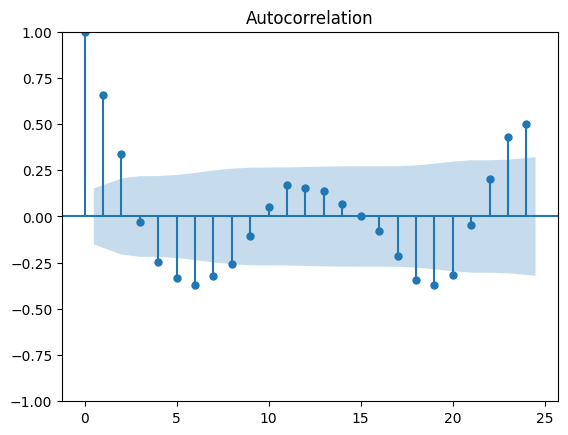

plotting agent 1


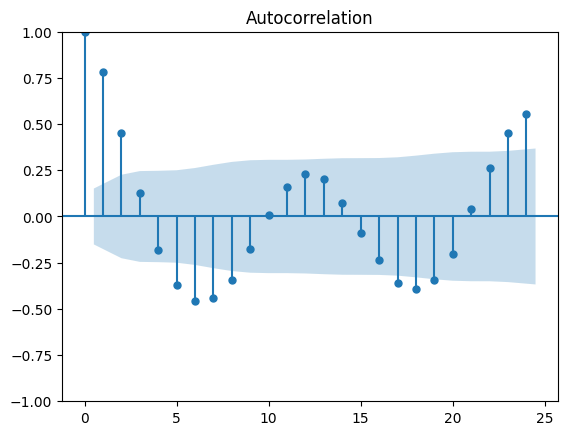

plotting agent 2


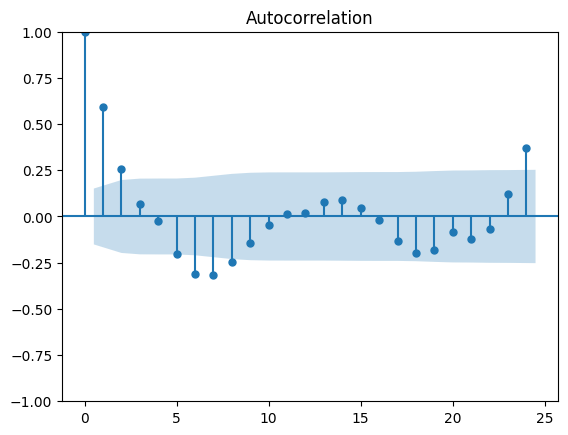

plotting agent 3


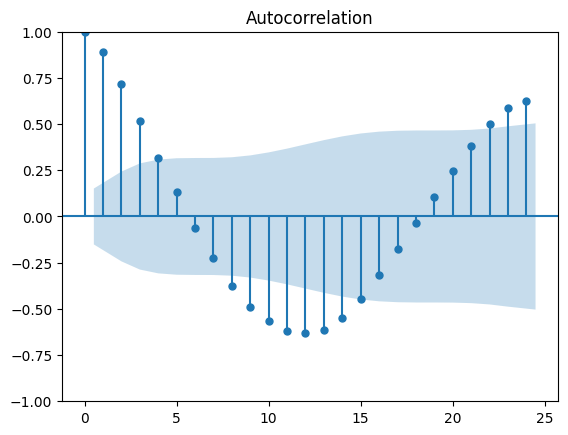

plotting agent 4


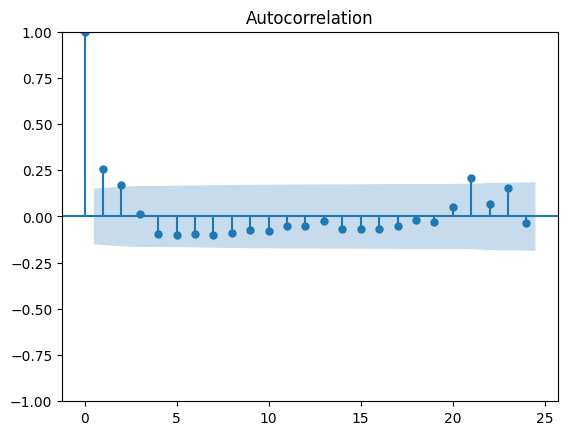

plotting agent 5


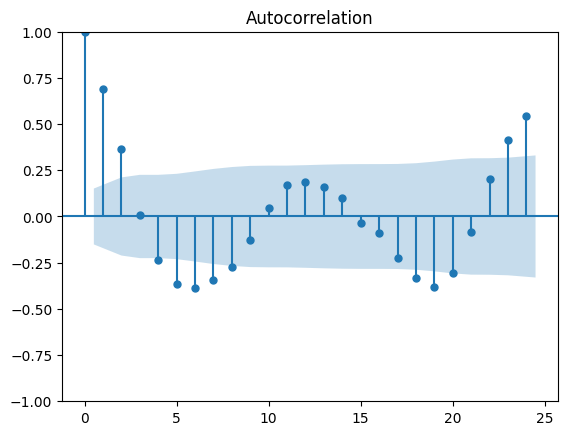

plotting agent 6


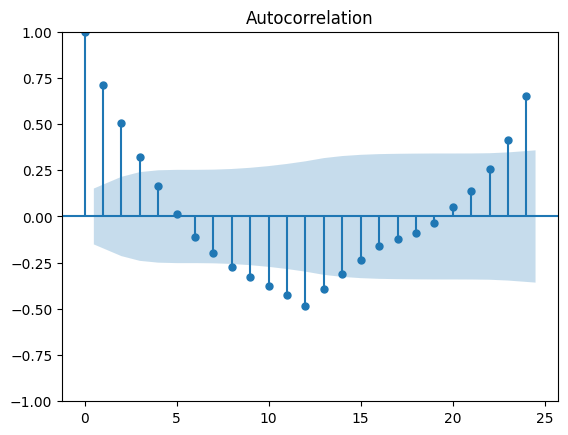

plotting agent 7


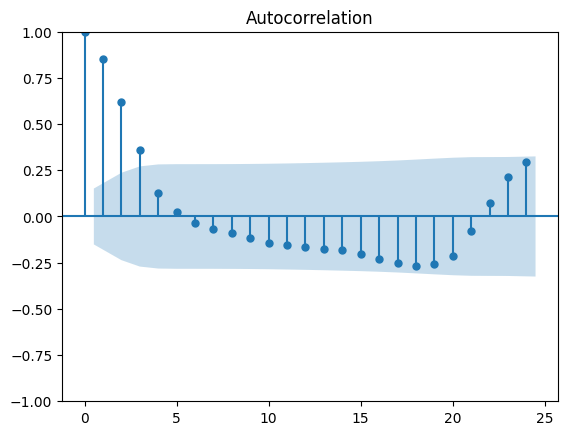

plotting agent 8


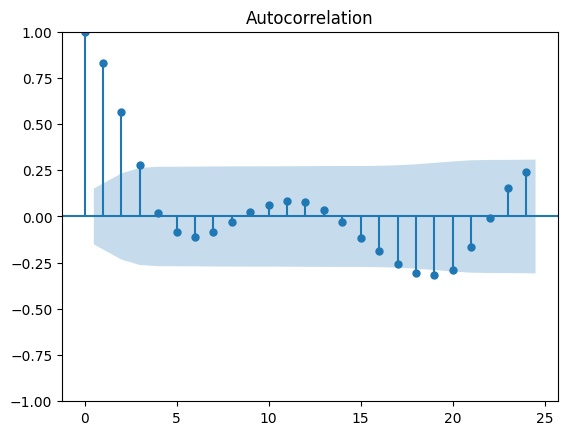

plotting agent 9


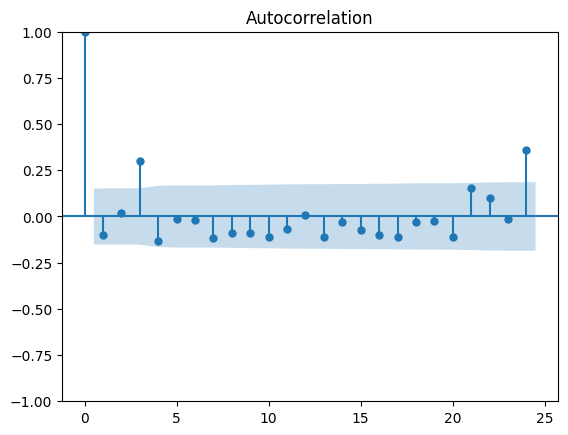

plotting agent 10


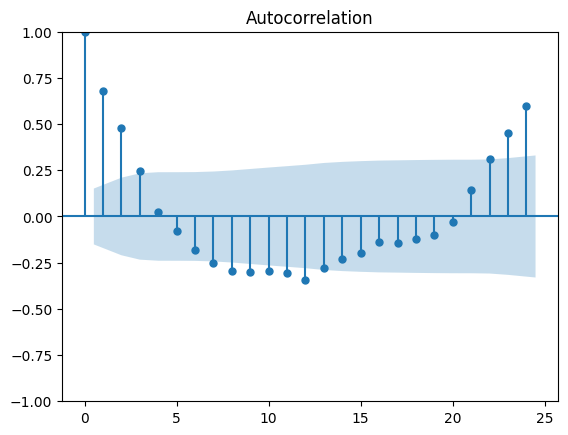

plotting agent 11


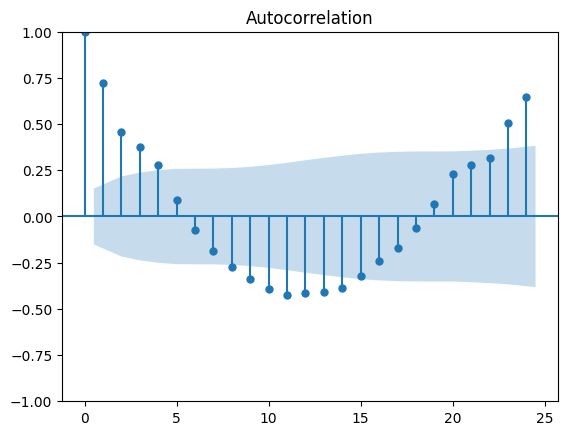

plotting agent 12


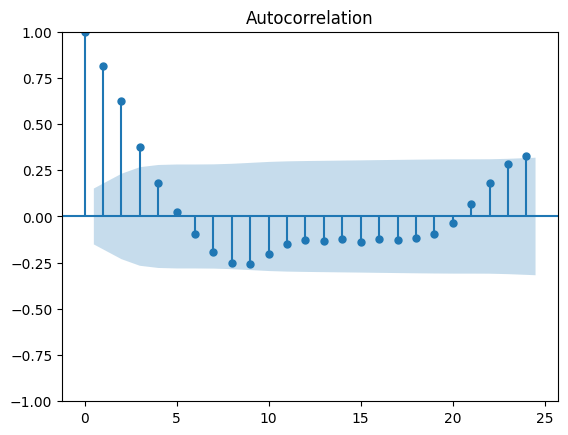

plotting agent 13


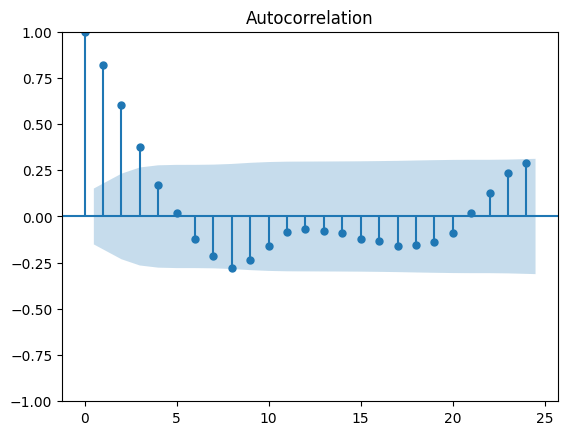

plotting agent 14


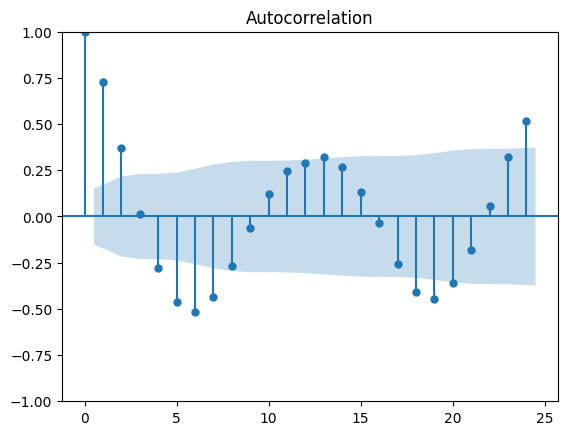

plotting agent 15


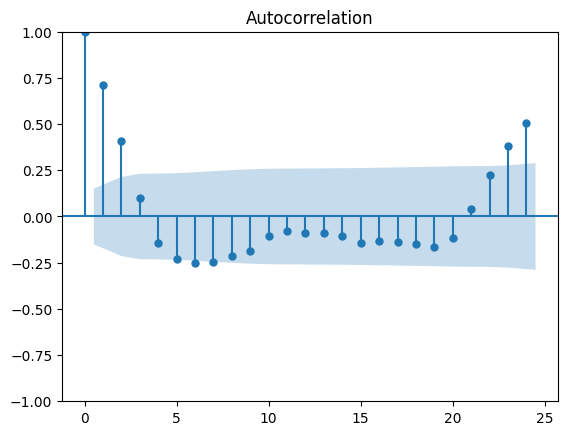

plotting agent 16


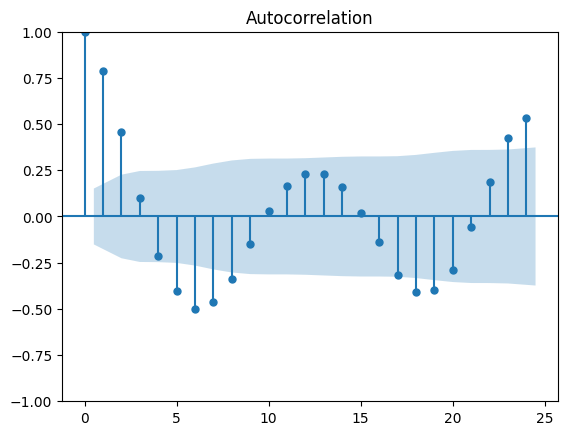

plotting agent 17


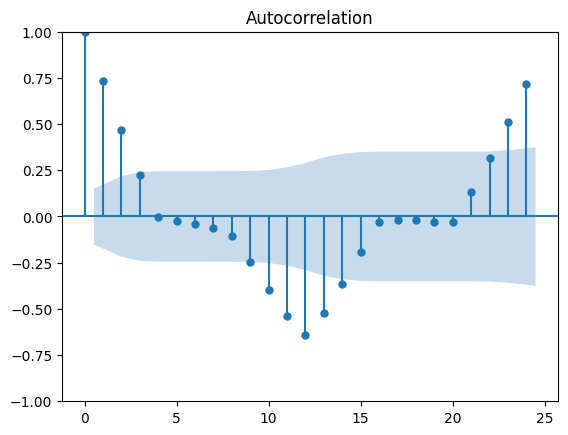

plotting agent 18


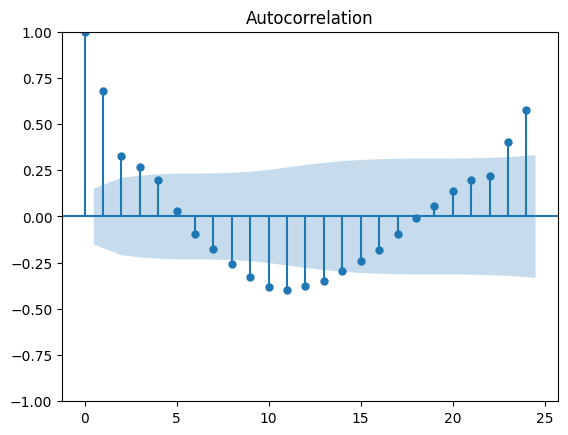

plotting agent 19


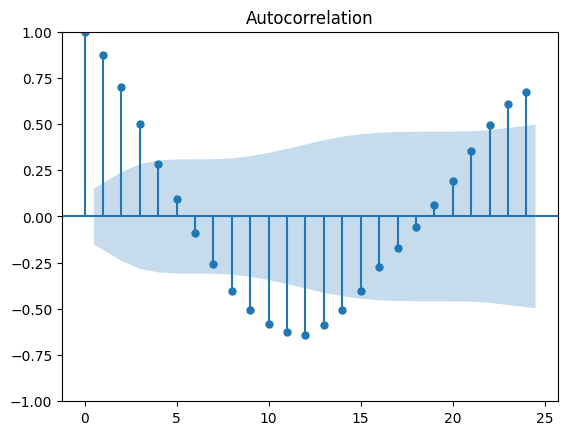

plotting agent 20


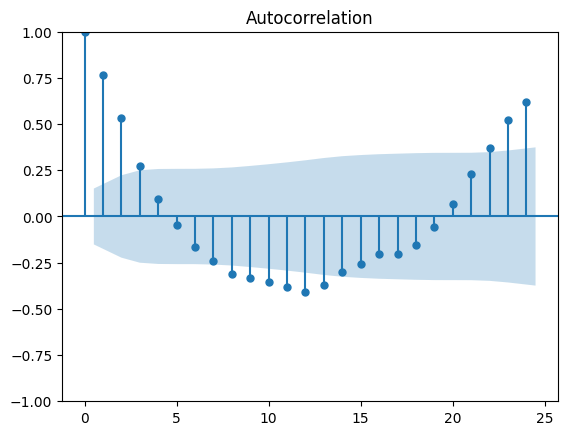

plotting agent 21


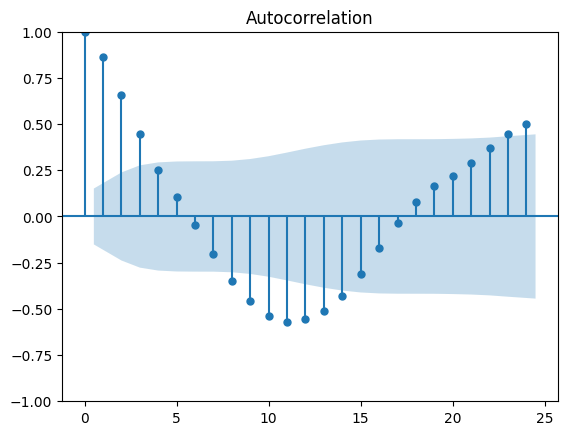

plotting agent 22


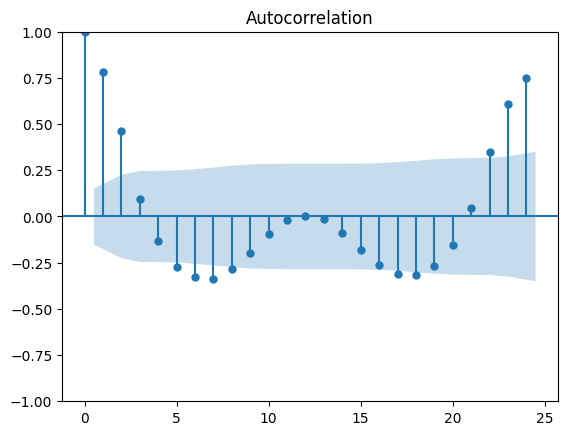

plotting agent 23


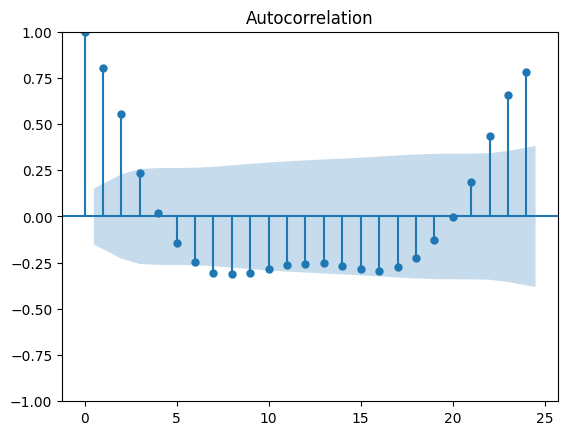

plotting agent 24


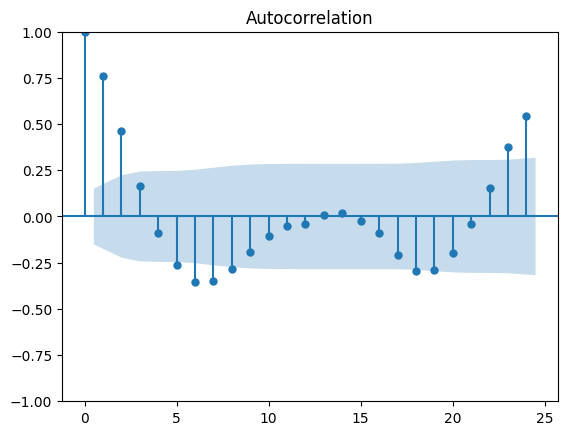

plotting agent 25


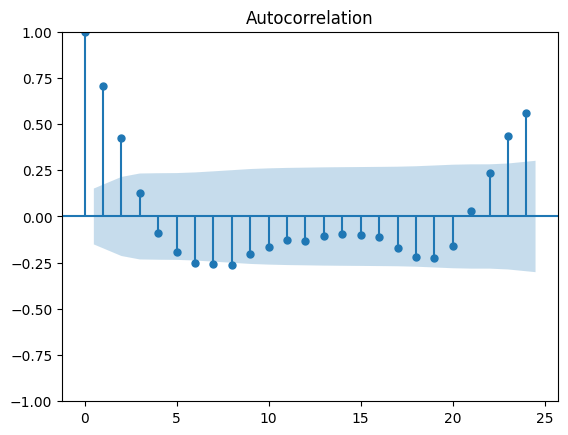

plotting agent 26


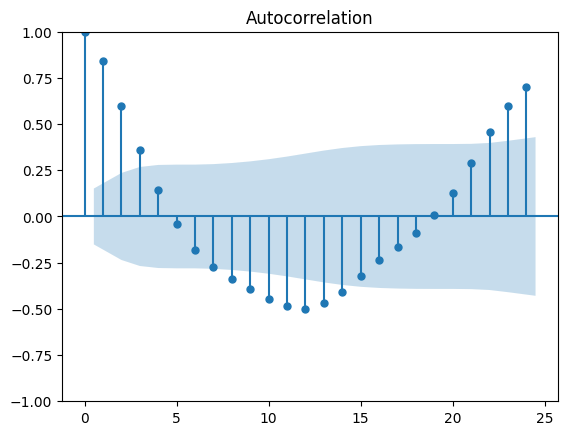

plotting agent 27


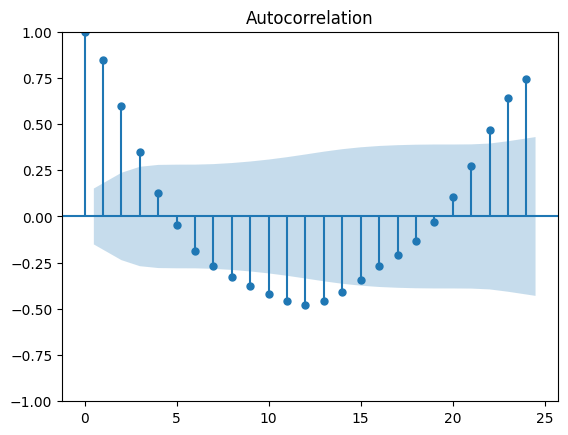

plotting agent 28


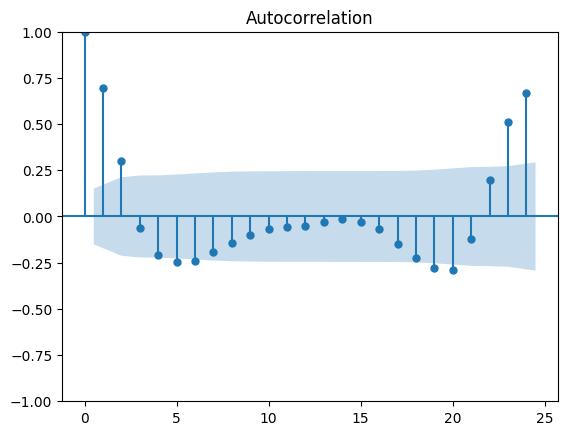

plotting agent 29


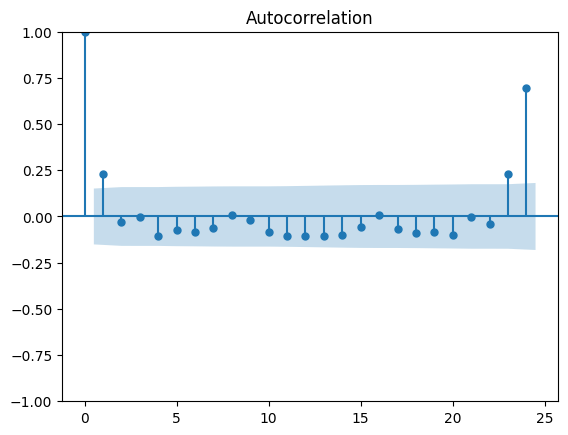

In [144]:
def plot1():
    for _agent in agent_stats_df.agentIndex.unique():
        print(f"plotting agent {int(_agent)}")
        curr_agent = agent_stats_df[agent_stats_df["agentIndex"].eq(_agent)].reset_index(drop=True)
        
        # sns.lineplot(x=curr_agent["timeIndex"], y=agent_stats_df["status"])
        plot_acf(curr_agent["bid"], lags=24)
        plt.show()

plot1()

plotting agent 0, category=0


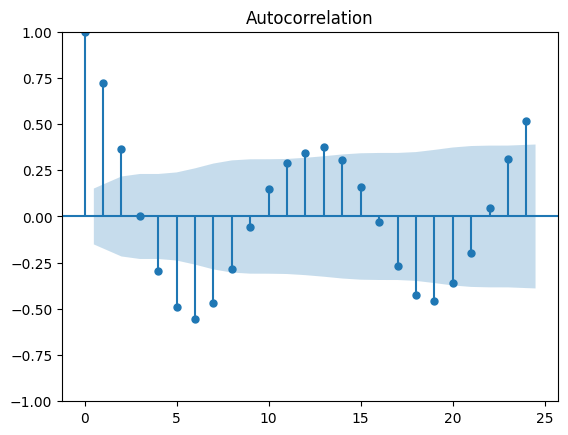

plotting agent 1, category=0


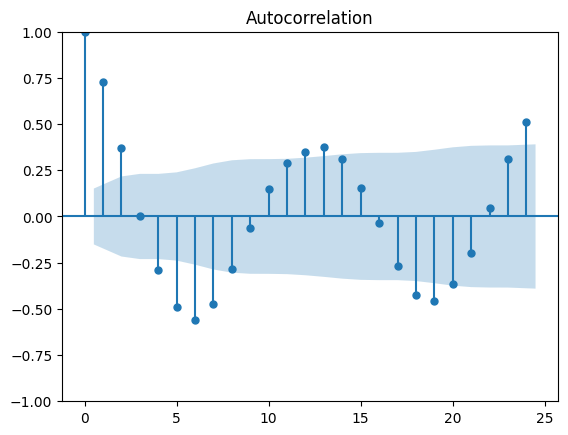

plotting agent 2, category=0


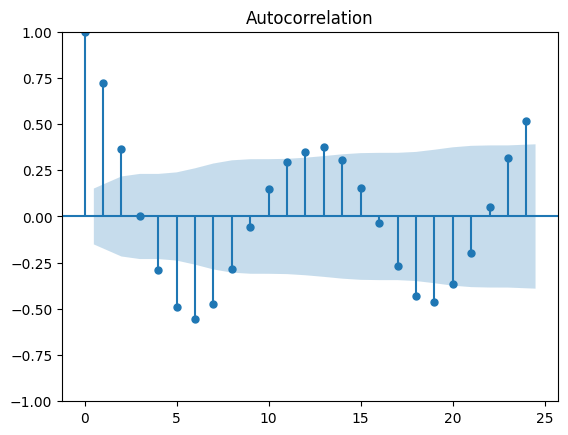

plotting agent 3, category=0


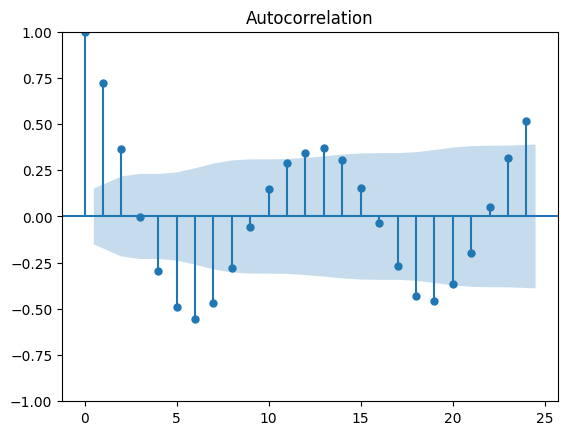

plotting agent 4, category=0


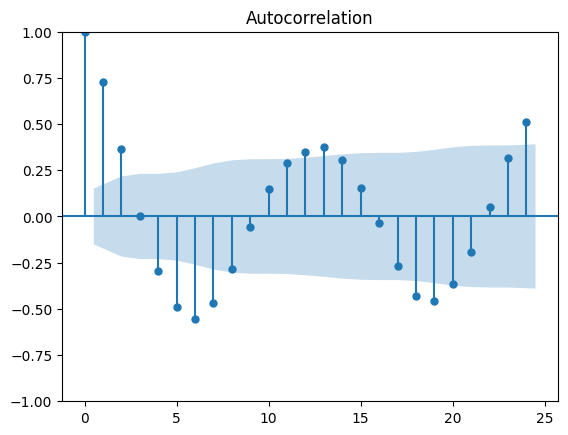

plotting agent 5, category=0


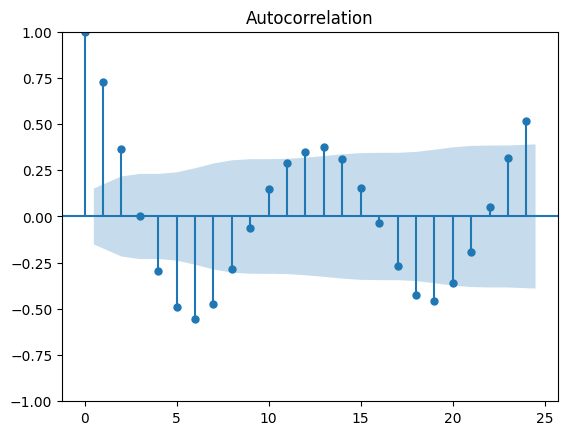

plotting agent 6, category=1


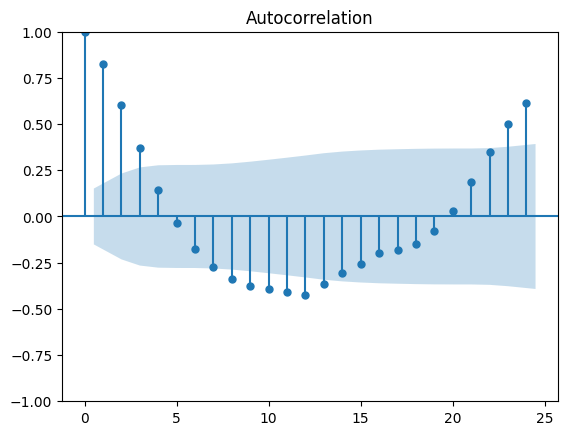

plotting agent 7, category=1


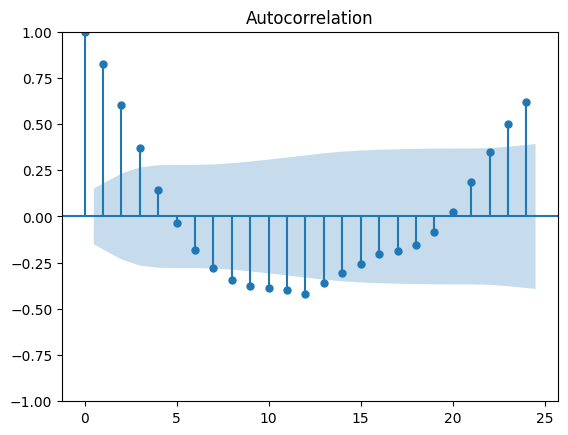

plotting agent 8, category=1


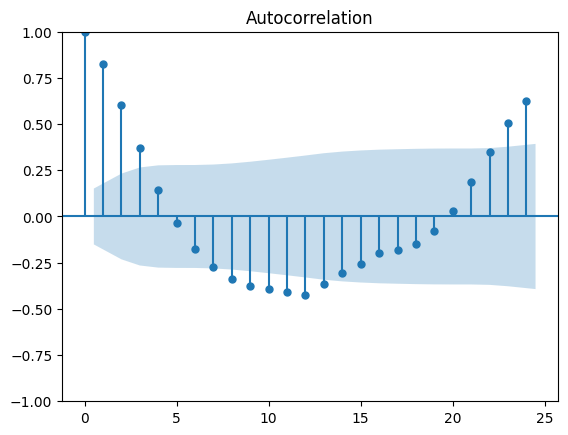

plotting agent 9, category=1


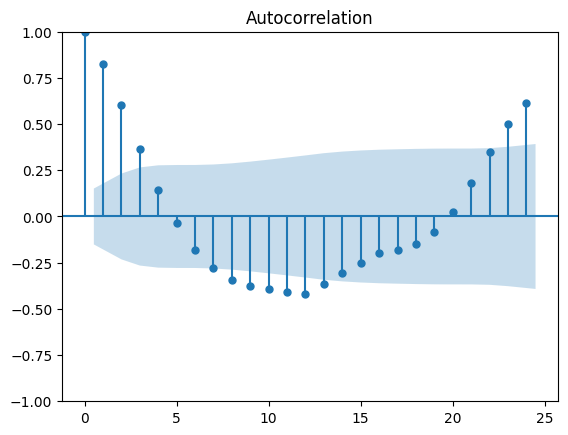

plotting agent 10, category=1


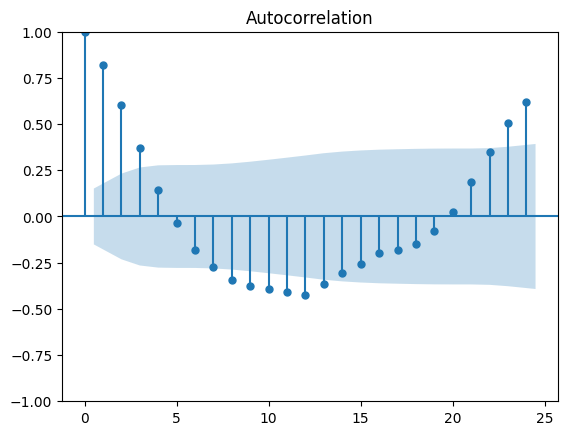

plotting agent 11, category=1


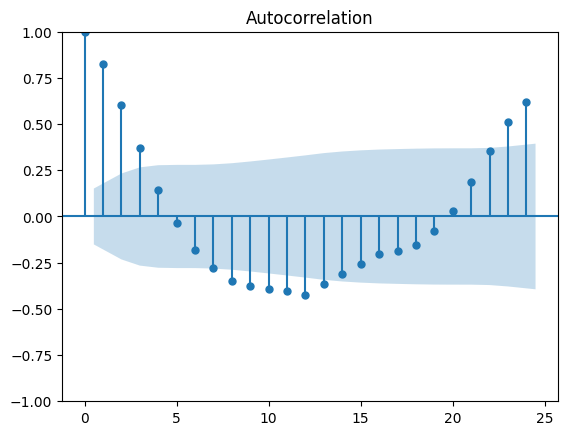

plotting agent 12, category=2


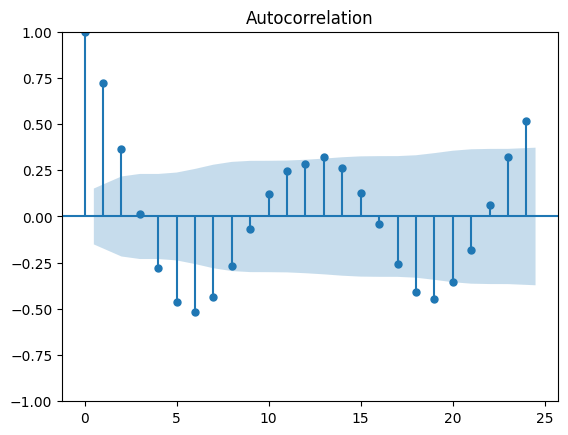

plotting agent 13, category=2


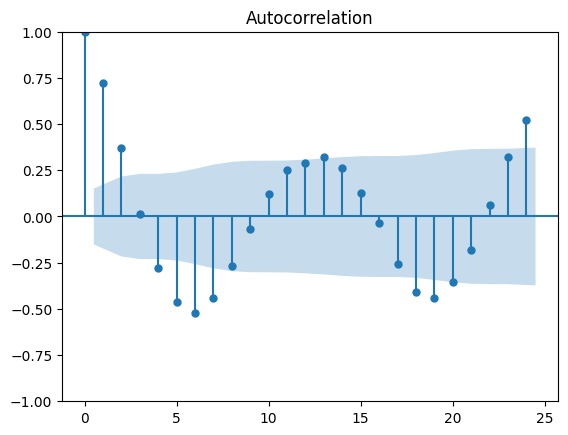

plotting agent 14, category=2


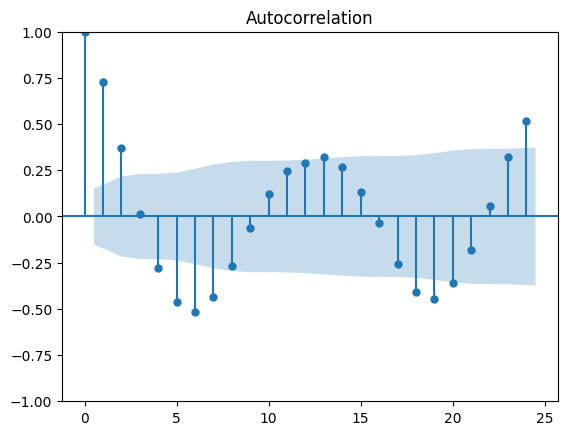

plotting agent 15, category=2


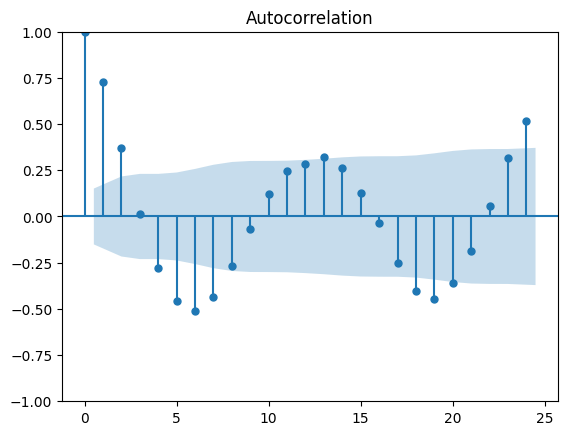

plotting agent 16, category=2


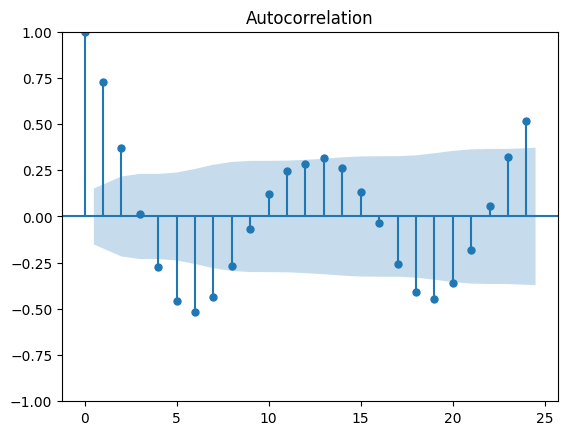

plotting agent 17, category=2


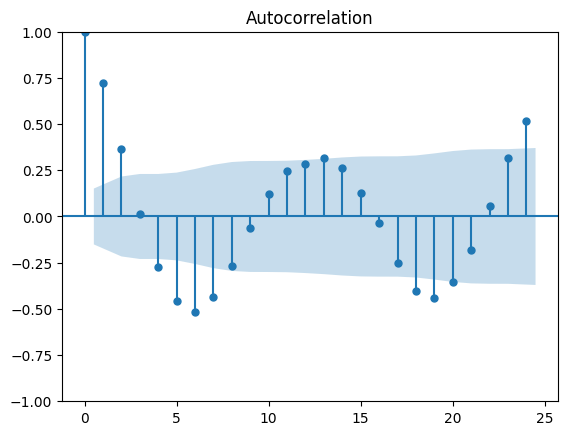

plotting agent 18, category=3


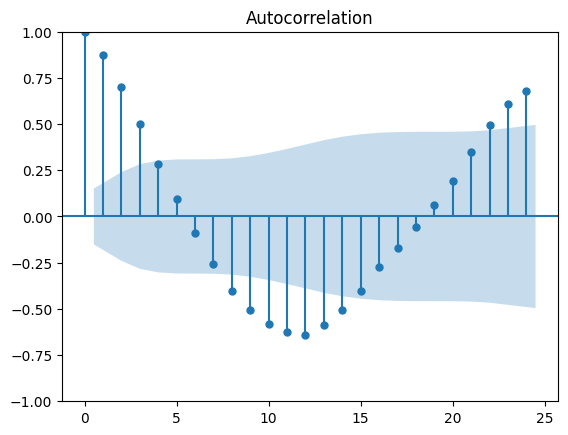

plotting agent 19, category=3


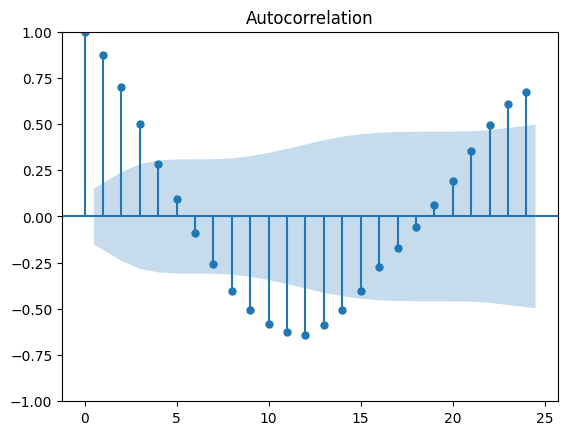

plotting agent 20, category=3


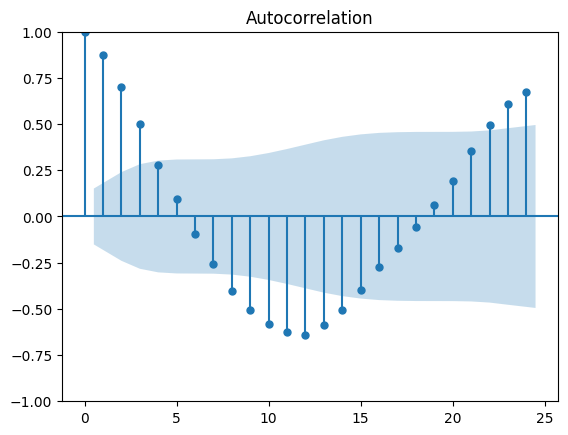

plotting agent 21, category=3


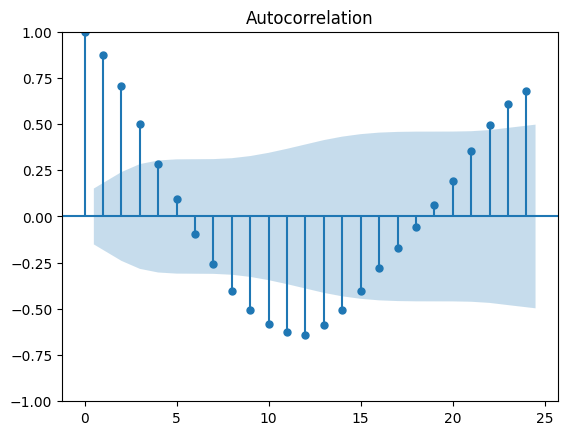

plotting agent 22, category=3


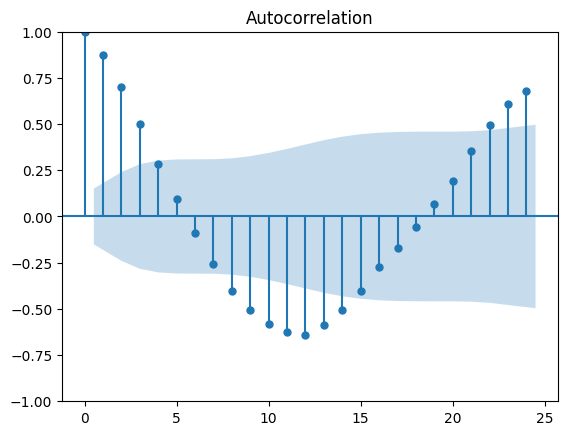

plotting agent 23, category=3


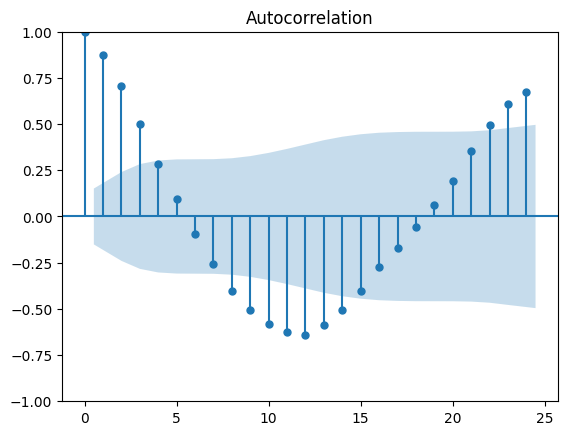

plotting agent 24, category=4


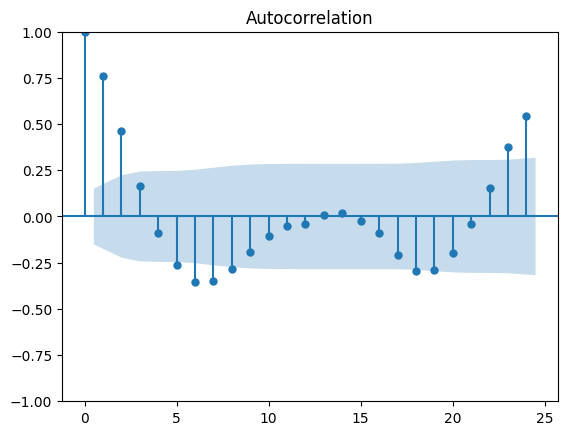

plotting agent 25, category=4


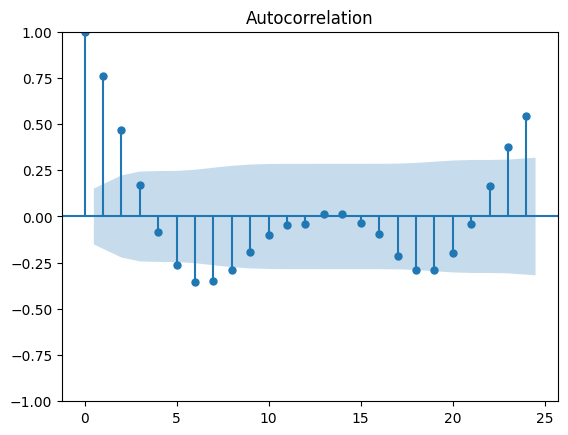

plotting agent 26, category=4


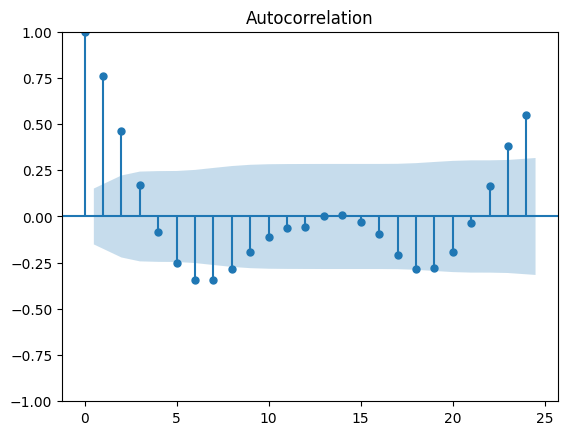

plotting agent 27, category=4


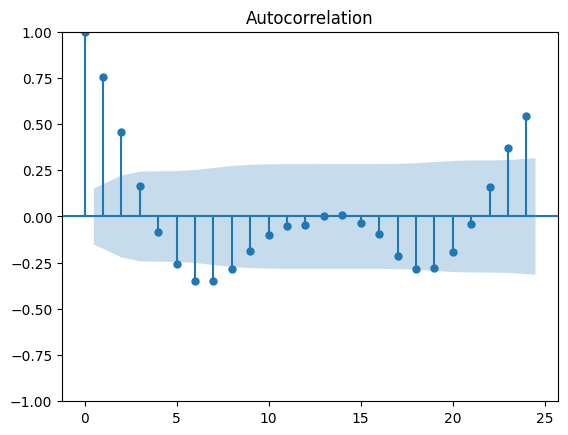

plotting agent 28, category=4


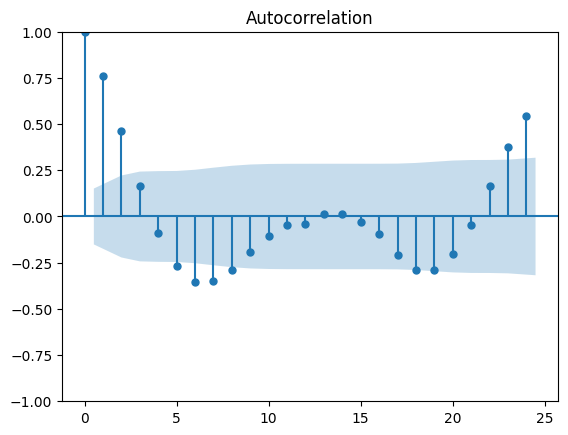

plotting agent 29, category=4


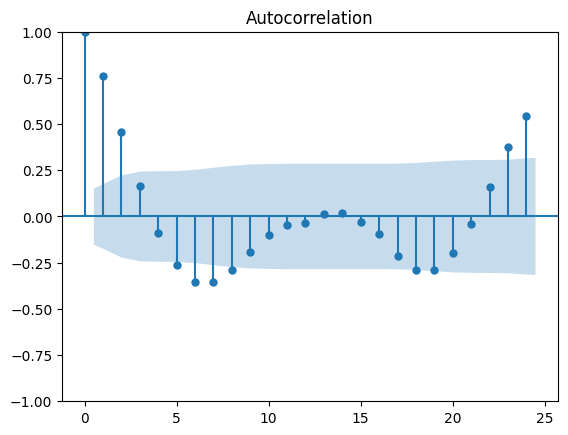

In [73]:
for _agent in agent_stats_df.agentIndex.unique():
    cat = agent_stats_df.loc[agent_stats_df.agentIndex.eq(_agent), "agentCategory"].to_list()[0]
    print(f"plotting agent {int(_agent)}, category={int(cat)}")
    plot_acf(agent_stats_df.loc[agent_stats_df.agentIndex.eq(_agent), "pvValue"], lags=24)
    plt.show()

In [20]:
log[log["pvIndex"].eq(3000) & log["episode"].eq(0) & log["tick"].eq(4)].sort_values("bid", ascending=False)

,episode,tick,agentIndex,agentCategory,budget,remainingBudget,Reward,done,pvIndex,pvValue,bid,status,marketPrice,cost
200625,0.0,4.0,9.0,1.0,2400.0,1987.032864,0.230365,0.0,3000.0,0.230365,2.344882,1.0,0.577618,1.993022
264525,0.0,4.0,29.0,4.0,3000.0,1906.734432,0.106386,0.0,3000.0,0.132983,1.993022,1.0,0.577618,0.505921
194235,0.0,4.0,7.0,1.0,1800.0,1748.697739,0.169812,0.0,3000.0,0.283020,0.632401,1.0,0.577618,0.346571
238965,0.0,4.0,21.0,3.0,2400.0,1949.602058,0.000000,0.0,3000.0,0.664159,0.577618,0.0,0.577618,0.000000
242160,0.0,4.0,22.0,3.0,2700.0,2451.909701,0.000000,0.0,3000.0,0.513530,0.464603,0.0,0.577618,0.000000
235770,0.0,4.0,20.0,3.0,2100.0,1920.413995,0.000000,0.0,3000.0,0.602654,0.431160,0.0,0.577618,0.000000
197430,0.0,4.0,8.0,1.0,2100.0,2085.385850,0.000000,0.0,3000.0,0.230975,0.407054,0.0,0.577618,0.000000
203820,0.0,4.0,10.0,1.0,2700.0,2591.414688,0.000000,0.0,3000.0,0.246244,0.365180,0.0,0.577618,0.000000
232575,0.0,4.0,19.0,3.0,1800.0,1789.500185,0.000000,0.0,3000.0,0.586966,0.322831,0.0,0.577618,0.000000
207015,0.0,4.0,11.0,1.0,3000.0,2781.260004,0.000000,0.0,3000.0,0.153766,0.263764,0.0,0.577618,0.000000


In [198]:
log[log["pvIndex"].eq(2000) & log["episode"].eq(0) & log["tick"].eq(4)].sort_values("bid", ascending=False)

,episode,tick,agentIndex,agentCategory,budget,remainingBudget,Reward,done,pvIndex,pvValue,bid,status,marketPrice,cost
263525,0.0,4.0,29.0,4.0,3000.0,1906.734432,0.168014,0.0,2000.0,0.168014,2.518036,1.0,0.285642,0.361103
180455,0.0,4.0,3.0,0.0,2400.0,1791.576973,0.284326,0.0,2000.0,0.355407,0.361103,1.0,0.285642,0.281689
174065,0.0,4.0,1.0,0.0,1800.0,1669.193312,0.249011,0.0,2000.0,0.415018,0.352112,1.0,0.285642,0.171385
199625,0.0,4.0,9.0,1.0,2400.0,1987.032864,0.000000,0.0,2000.0,0.028062,0.285642,0.0,0.285642,0.000000
170870,0.0,4.0,0.0,0.0,1500.0,1460.079552,0.000000,0.0,2000.0,0.305371,0.283044,0.0,0.285642,0.000000
206015,0.0,4.0,11.0,1.0,3000.0,2781.260004,0.000000,0.0,2000.0,0.166532,0.270878,0.0,0.285642,0.000000
186845,0.0,4.0,5.0,0.0,3000.0,2933.324764,0.000000,0.0,2000.0,0.244925,0.236245,0.0,0.285642,0.000000
250745,0.0,4.0,25.0,4.0,1800.0,1733.697607,0.000000,0.0,2000.0,0.130253,0.231270,0.0,0.285642,0.000000
212405,0.0,4.0,13.0,2.0,1800.0,1792.588370,0.000000,0.0,2000.0,0.273062,0.217482,0.0,0.285642,0.000000
177260,0.0,4.0,2.0,0.0,2100.0,1328.589284,0.000000,0.0,2000.0,0.358215,0.208097,0.0,0.285642,0.000000
